In [1]:
import glob
import os
import pickle
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import scipy
import seaborn as sns
from matplotlib import ticker

import extq
import prettypyplot as pplt

In [2]:
! source /project/dinner/scguo/upside2/sourceme.sh

In [3]:
# upside_path = os.environ["UPSIDE_HOME"]
upside_path = "/project/dinner/scguo/upside2/"
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)

In [4]:
plt.style.use("custom")  # custom style sheet
plt.style.use("vibrant")  # muted color theme from SciencePlots
pplt.load_cmaps()

In [5]:
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "cm"

In [6]:
def load_cvs(base_dir, n_s, n_i):
    raw_feats, fs_qtots, f_rmsds, p_rmsds, r_rmsds, dssps, omegas = [], [], [], [], [], [], []
    for i in range(n_s):
        for j in range(n_i):
            for iso in ("cis", "trans"):
                idx = f"{i:02}_{j:02}_{iso}"
                head = f"{idx}_dga"
                if not os.path.exists(f"{base_dir}/{idx}/outputs/{head}_raw_feats.pkl"):
                    continue
                raw_feats.extend(
                    np.load(f"{base_dir}/{idx}/outputs/{head}_raw_feats.pkl", allow_pickle=True)
                )
                fs_qtots.extend(np.load(f"{base_dir}/{idx}/outputs/{head}_fs_qtots.pkl", allow_pickle=True))
                f_rmsds.extend(np.load(f"{base_dir}/{idx}/outputs/{head}_f_rmsds.pkl", allow_pickle=True))
                p_rmsds.extend(np.load(f"{base_dir}/{idx}/outputs/{head}_p_rmsds.pkl", allow_pickle=True))
                r_rmsds.extend(np.load(f"{base_dir}/{idx}/outputs/{head}_r_rmsds.pkl", allow_pickle=True))
                for k in range(2):
                    if not os.path.exists(f"{base_dir}/{idx}/outputs/{idx}_{k:02}_Omega.npy"):
                        continue
                    omegas.append(np.load(f"{base_dir}/{idx}/outputs/{idx}_{k:02}_Omega.npy"))
                    dssps.append(np.load(f"{base_dir}/{idx}/outputs/{idx}_{k:02}_dssp.npy"))
    return raw_feats, fs_qtots, f_rmsds, p_rmsds, r_rmsds, omegas, dssps

In [7]:
def plot_q_avg(qall, q1, q2, cvs, weights, weights1, weights2, ylim, ylabel):
    xe = np.linspace(0, 1, 51)
    ye = np.linspace(ylim[0], ylim[1], 51)
    traj_len = len(cvs[0])
    # split into 2 blocks
    cvs1 = np.array(cvs)[:, : traj_len // 2]
    cvs2 = np.array(cvs)[:, traj_len // 2 :]

    f, axes = plt.subplots(1, 3, figsize=(6, 2), dpi=250, constrained_layout=True)
    for ax, q, cv, w in zip(axes, [qall, q1, q2], [cvs, cvs1, cvs2], [weights, weights1, weights2]):
        # print(q.shape, cv.shape, w.shape)
        dens = extq.projection.density2d(q, cv, w, xe, ye)
        pmf = -np.log(dens)
        pmf -= np.min(pmf)
        pc = ax.pcolormesh(xe, ye, pmf.T, vmax=14)
        plt.colorbar(pc, ax=ax, location="top")
        ax.set_xlabel("$q$")
        ax.set_ylabel(ylabel)
        ax.label_outer()
    axes[0].set_title("All data")
    axes[1].set_title("First half")
    axes[2].set_title("Second half")
    return f, axes

In [8]:
def plot_q_proj(qall, q1, q2, cvsx, cvsy, weights, weights1, weights2, xlim, ylim, xlabel, ylabel):
    xe = np.linspace(xlim[0], xlim[1], 51)
    ye = np.linspace(ylim[0], ylim[1], 51)
    traj_len = len(cvsx[0])
    # split into 2 blocks
    cvsx1 = np.array(cvsx)[:, : traj_len // 2]
    cvsx2 = np.array(cvsx)[:, traj_len // 2 :]
    cvsy1 = np.array(cvsy)[:, : traj_len // 2]
    cvsy2 = np.array(cvsy)[:, traj_len // 2 :]

    f, axes = plt.subplots(1, 3, figsize=(6.5, 2), dpi=250, constrained_layout=True)
    for ax, q, cvx, cvy, w in zip(
        axes, [qall, q1, q2], [cvsx, cvsx1, cvsx2], [cvsy, cvsy1, cvsy2], [weights, weights1, weights2]
    ):
        # print(q.shape, cv.shape, w.shape)
        q_dens = extq.projection.average2d(cvx, cvy, q, w, xe, ye)
        pc = ax.pcolormesh(xe, ye, q_dens.T, vmin=0, vmax=1, cmap="nightfall")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.label_outer()
    axes[0].set_title("All data")
    axes[1].set_title("First half")
    axes[2].set_title("Second half")
    plt.colorbar(pc, ax=axes[-1], location="right")
    return f, axes

In [10]:
def plot_q_3d(qall, q1, q2, cvsx, cvsy, cvsz, xlabel, ylabel, zlabel):
    traj_len = len(cvsx[0])
    for i, q in enumerate([qall, q1, q2]):
        # split into 2 blocks
        if i == 0:
            cvx = np.ravel(cvsx)
            cvy = np.ravel(cvsy)
            cvz = np.ravel(cvsz)
        elif i == 1:
            cvx = np.ravel(np.array(cvsx)[:, : traj_len // 2])
            cvy = np.ravel(np.array(cvsy)[:, : traj_len // 2])
            cvz = np.ravel(np.array(cvsz)[:, : traj_len // 2])
        elif i == 2:
            cvx = np.ravel(np.array(cvsx)[:, traj_len // 2 :])
            cvy = np.ravel(np.array(cvsy)[:, traj_len // 2 :])
            cvz = np.ravel(np.array(cvsz)[:, traj_len // 2 :])

        fig = plt.figure(figsize=(4, 4), dpi=300)
        q_arr = np.ravel(q)
        N = len(q_arr)
        skip = 100
        sc_ind = np.random.choice(N, N // skip)

        ax = fig.add_subplot(projection="3d")
        sc = ax.scatter(
            cvx[sc_ind],
            cvy[sc_ind],
            cvz[sc_ind],
            "o",
            c=q_arr[sc_ind],
            cmap="nightfall",
            alpha=0.1,
            s=10,
            rasterized=True,
            vmin=0,
            vmax=1,
        )
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_zlabel(zlabel)
        ax.grid(True)
        cb = plt.colorbar(sc, ax=ax, shrink=0.5, location="top", pad=0, label=labels["qp"])
        cb.solids.set(alpha=1)
        ax.view_init(elev=30, azim=-110)

In [56]:
from collections import OrderedDict
from itertools import product


def assign_proline_states(omegas):
    p63_cis, p70_cis, p71_cis, p72_cis = [], [], [], []
    for omega in omegas:
        p63_cis.append((np.abs(omega[:, 3]) <= (np.pi / 2.0)).astype(bool))
        p70_cis.append((np.abs(omega[:, 4]) <= (np.pi / 2.0)).astype(bool))
        p71_cis.append((np.abs(omega[:, 5]) <= (np.pi / 2.0)).astype(bool))
        p72_cis.append((np.abs(omega[:, 6]) <= (np.pi / 2.0)).astype(bool))
    p63_cis = np.ravel(p63_cis)
    p70_cis = np.ravel(p70_cis)
    p71_cis = np.ravel(p71_cis)
    p72_cis = np.ravel(p72_cis)

    # assign proline states
    dtraj = np.zeros_like(p63_cis, dtype=int)
    state_dict = OrderedDict()
    fn_seq_iterator = product([lambda x: x, np.logical_not], repeat=4)
    for i, (state, fn_seq) in enumerate(zip(product("CT", repeat=4), fn_seq_iterator)):
        # fn_seq is something like (Identity, ~, Identity, ~)
        seq = fn_seq[0](p63_cis) & fn_seq[1](p70_cis) & fn_seq[2](p71_cis) & fn_seq[3](p72_cis)
        state_name = "".join(state)
        print(f"{state_name}: {np.count_nonzero(seq) / len(seq) * 100:6.3f}%")
        state_dict[state_name] = i
        dtraj[seq] = i
    return state_dict, dtraj


def compute_cis_state_frac(dtraj, weights=None):
    if weights is None:
        weights = np.ones_like(dtraj, dtype=float)
    ans = np.zeros(16, dtype=float)
    for i in range(16):
        ans[i] = np.sum(np.where(dtraj == i, weights, 0))
    return ans / np.sum(weights)

In [64]:
def bin_inds(q, qstep=0.05, low=0, hi=1):
    q_arr = np.concatenate(q)
    nsteps = round((hi - low) / qstep)
    all_inds = []
    steps = np.linspace(low, hi - qstep, nsteps)
    for i, s in enumerate(steps):
        q_inds = ((q_arr >= s) & (q_arr <= s + qstep)).nonzero()[0]
        all_inds.append(q_inds)
    return steps, all_inds


def plot_proline_states(qall, q1, q2, dtrajall, dtraj1, dtraj2, state_dict):
    fig, axes = plt.subplots(
        ncols=3, nrows=5, figsize=(8, 8), dpi=200, sharex=True, sharey=True, constrained_layout=True
    )
    # color by number of cis
    colors = []
    for state in state_dict.keys():
        colors.append(f"C{state.count('T')}")

    for i, (q, dtraj) in enumerate(zip([qall, q1, q2], [dtrajall, dtraj1, dtraj2])):
        # bin by committor
        steps, q_inds = bin_inds(q, qstep=0.2, low=0, hi=1)

        for ax, step, inds in zip(axes[:, i], steps, q_inds):
            fraction = compute_cis_state_frac(dtraj[inds], weights=np.ravel(weights[1])[inds])
            ax.bar(range(16), fraction, align="center", color=colors)
            ax.set_xlim([-1, 16])
            ax.set_title(f"$q_+ \\in [{step:.1f}, {step + 0.2:.1f}]$")
            ax.set_xlabel("State")
            ax.set_ylabel("Fraction in state")
            sns.despine(ax=ax, top=True, right=True, bottom=False, left=False)
            ax.label_outer()
        axes[-1, i].set_xticks(
            np.arange(16),
            state_dict.keys(),
            ha="right",
            rotation_mode="anchor",
            rotation=45,
            fontsize=6,
            fontfamily="monospace",
        )
    axes[0, 0].set_title("All data")
    axes[0, 1].set_title("First half")
    axes[0, 2].set_title("Second half")

# T = 0.89

In [11]:
home_dir = "/project/dinner/scguo/kaiB"
temp = 89
base_dir = f"/project/dinner/scguo/kaiB/dga/{temp}"

In [12]:
_, fs_qtots, f_rmsds, p_rmsds, r_rmsds, omegas, dssps = load_cvs(base_dir, 7, 32)

In [13]:
# Adam's CVs
c_gsa1 = np.concatenate([traj[1, :] for traj in fs_qtots])
c_gsa2 = np.concatenate([traj[3, :] for traj in fs_qtots])
c_gsb2 = np.concatenate([traj[5, :] for traj in fs_qtots])

c_fsb1 = np.concatenate([traj[0, :] for traj in fs_qtots])
c_fsb2 = np.concatenate([traj[2, :] for traj in fs_qtots])
c_fsa2 = np.concatenate([traj[4, :] for traj in fs_qtots])

c_green_arr = c_gsa2 - c_fsb2
c_blue_arr = c_gsb2 - c_fsa2
c_orange_arr = c_gsa1 - c_fsb1

c_green = [traj[3, :] - traj[2, :] for traj in fs_qtots]
c_blue = [traj[5, :] - traj[4, :] for traj in fs_qtots]
c_orange = [traj[1, :] - traj[0, :] for traj in fs_qtots]

In [27]:
qp_gs2fs = {}
qp_fs2gs = {}
lags = [1000, 2000]
for lag in lags:
    for block in range(1, 3):
        qp_gs2fs[(block, lag)] = np.load(f"{base_dir}/dga_data/qp_gs2fs_lag{lag}_mem4_block{block}.npy")
        qp_gs2fs[lag] = np.load(f"{base_dir}/dga_data/qp_gs2fs_lag{lag}_mem4.npy")
        qp_fs2gs[(block, lag)] = np.load(f"{base_dir}/dga_data/qp_fs2gs_lag{lag}_mem4_block{block}.npy")
        qp_fs2gs[lag] = np.load(f"{base_dir}/dga_data/qp_fs2gs_lag{lag}_mem4.npy")

In [15]:
weights = np.load(f"{base_dir}/dga_data/weights.npy")[3:5]
weights_block1 = np.load(f"{base_dir}/dga_data/weights_block1.npy")[3:5]
weights_block2 = np.load(f"{base_dir}/dga_data/weights_block2.npy")[3:5]

In [16]:
names = ["blue", "green", "orange", "r_rmsd", "qp"]
labels = dict(
    blue=r"$\alpha3_{\mathrm{fs}}\longleftrightarrow \beta4_{\mathrm{gs}}$",
    green=r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$",
    orange=r"$\beta3_{\mathrm{fs}}\longleftrightarrow\alpha2_{\mathrm{gs}}$",
    r_rmsd=r"core RMSD (nm)",
    qp=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$",
)
cvs = dict(blue=c_blue, green=c_green, orange=c_orange, r_rmsd=r_rmsds)
lims = dict(blue=(-1, 1.3), green=(-1.3, 1), orange=(-1.3, 1), r_rmsd=(0, 1.2), qp=(0, 1))

/scratch/local/jobs/11297029/ipykernel_1754184/1631952783.py:13: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(dens)


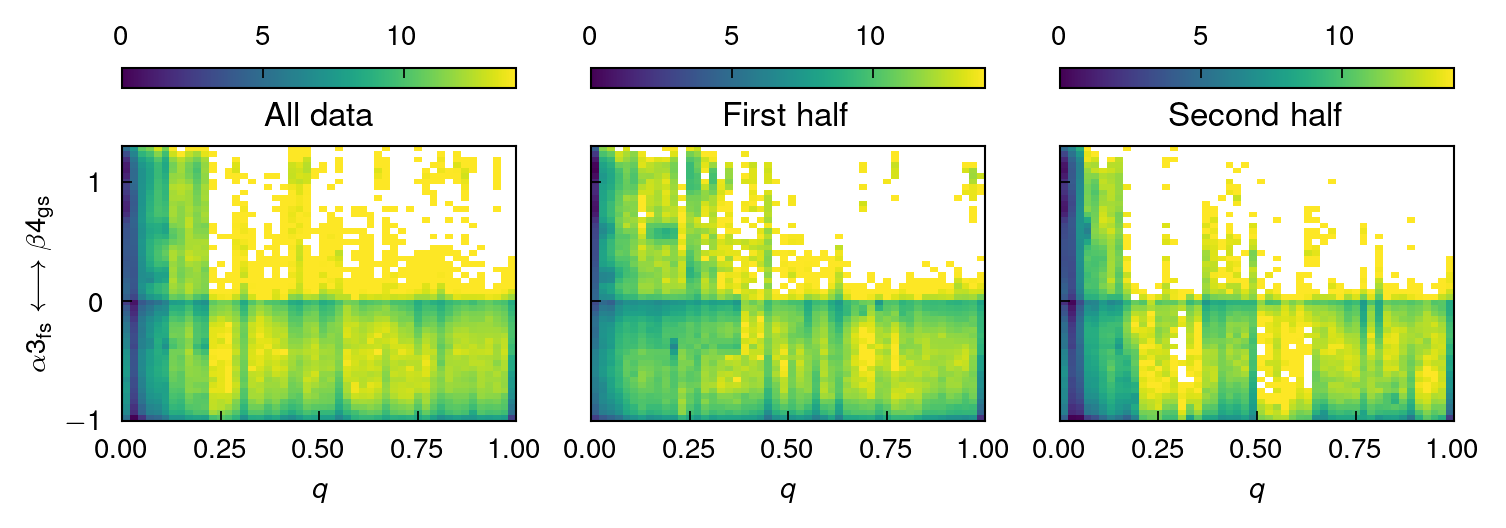

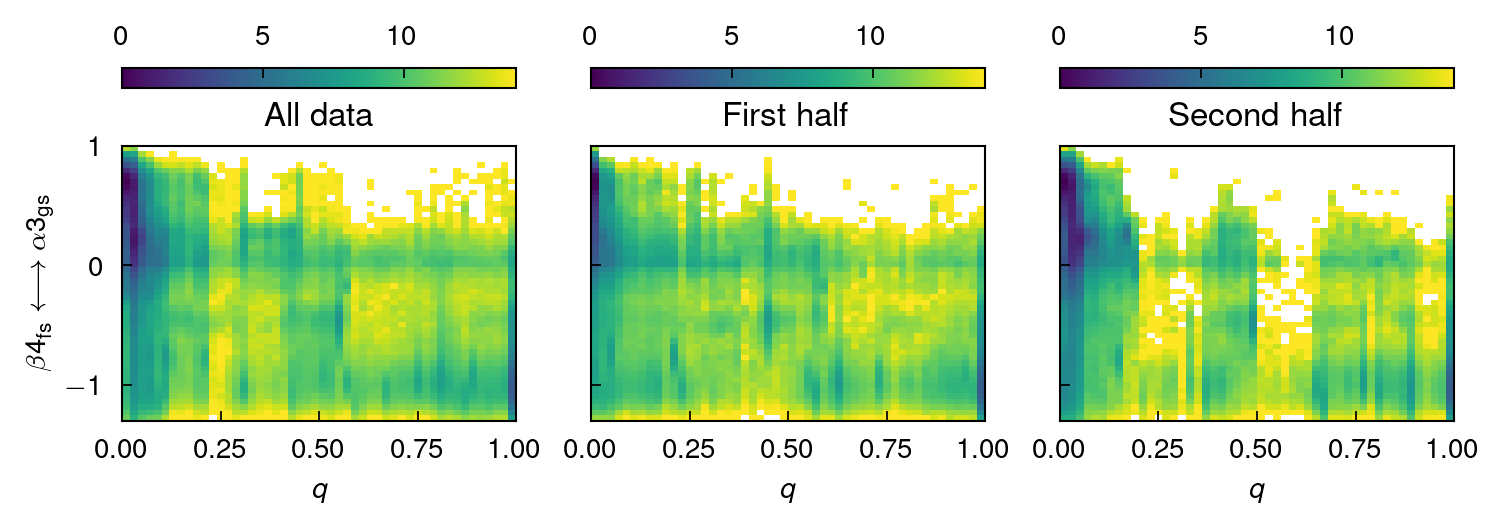

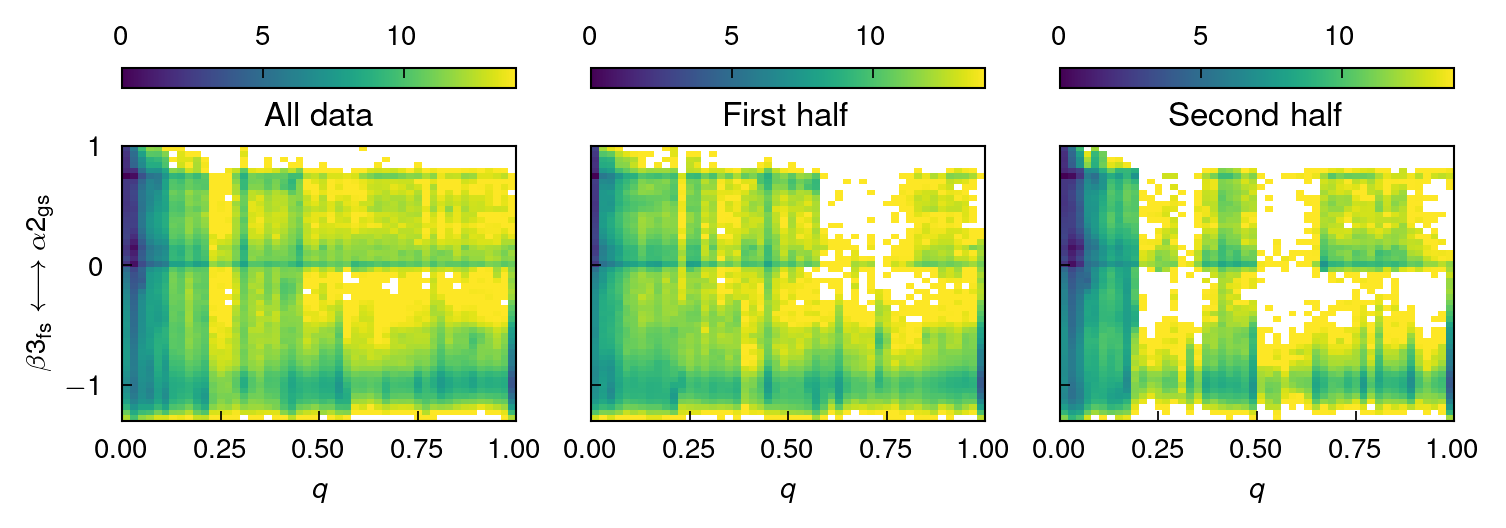

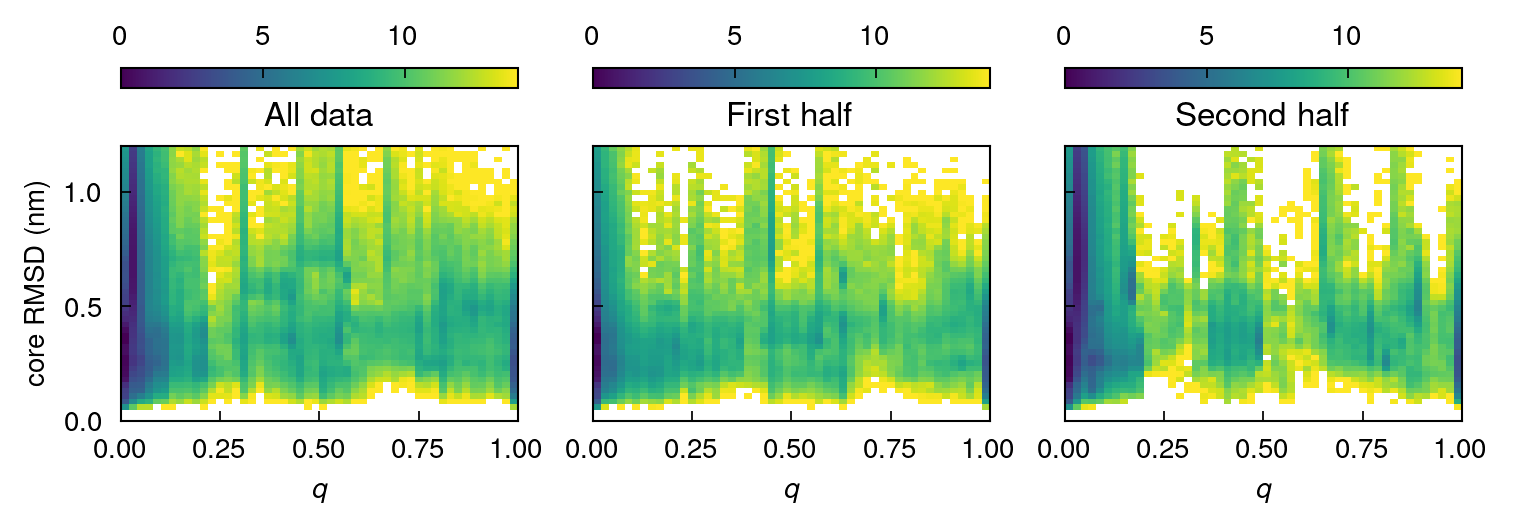

In [17]:
lag = 1000
for name in names[:4]:
    f, axes = plot_q_avg(
        qp_gs2fs[lag],
        qp_gs2fs[(1, lag)],
        qp_gs2fs[(2, lag)],
        cvs[name],
        weights[0],
        weights_block1[0],
        weights_block2[0],
        lims[name],
        labels[name],
    )

/project/dinner/scguo/extq/src/extq/projection.py:145: RuntimeWarning: invalid value encountered in divide
  return numer / denom


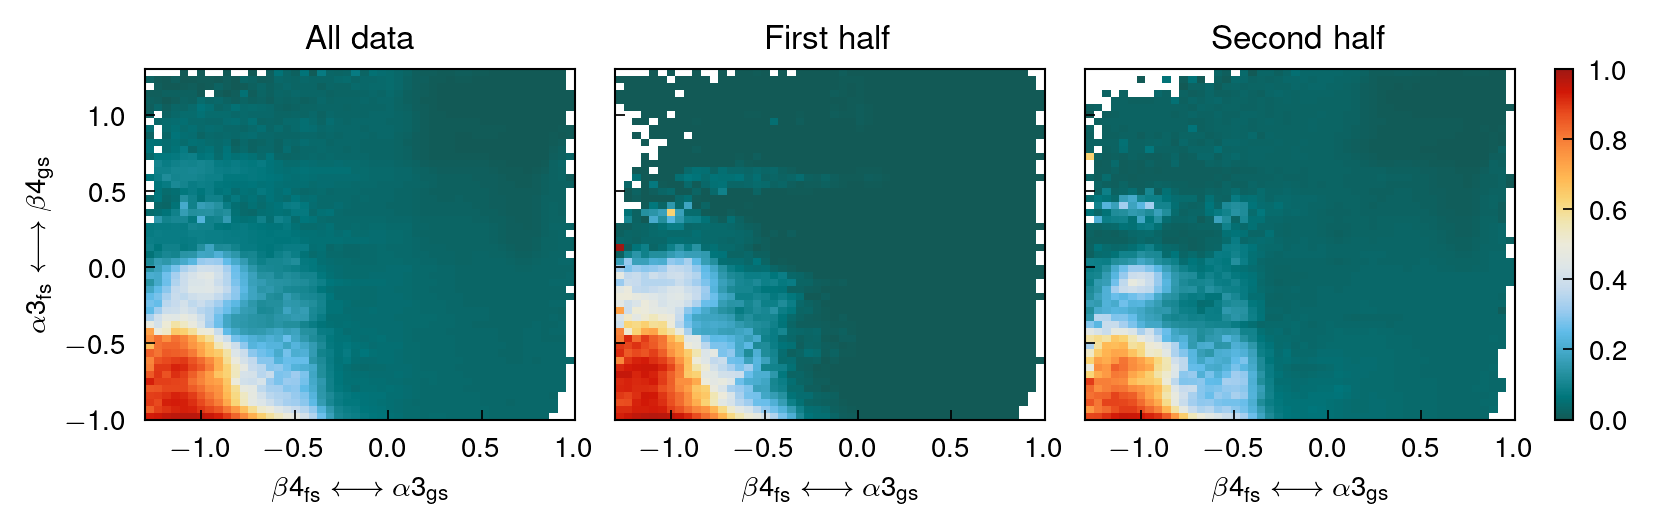

In [18]:
lag = 1000
cv1, cv2 = "green", "blue"
f, axes = plot_q_proj(
    qp_gs2fs[lag],
    qp_gs2fs[(1, lag)],
    qp_gs2fs[(2, lag)],
    cvs[cv1],
    cvs[cv2],
    weights[0],
    weights_block1[0],
    weights_block2[0],
    lims[cv1],
    lims[cv2],
    labels[cv1],
    labels[cv2],
)

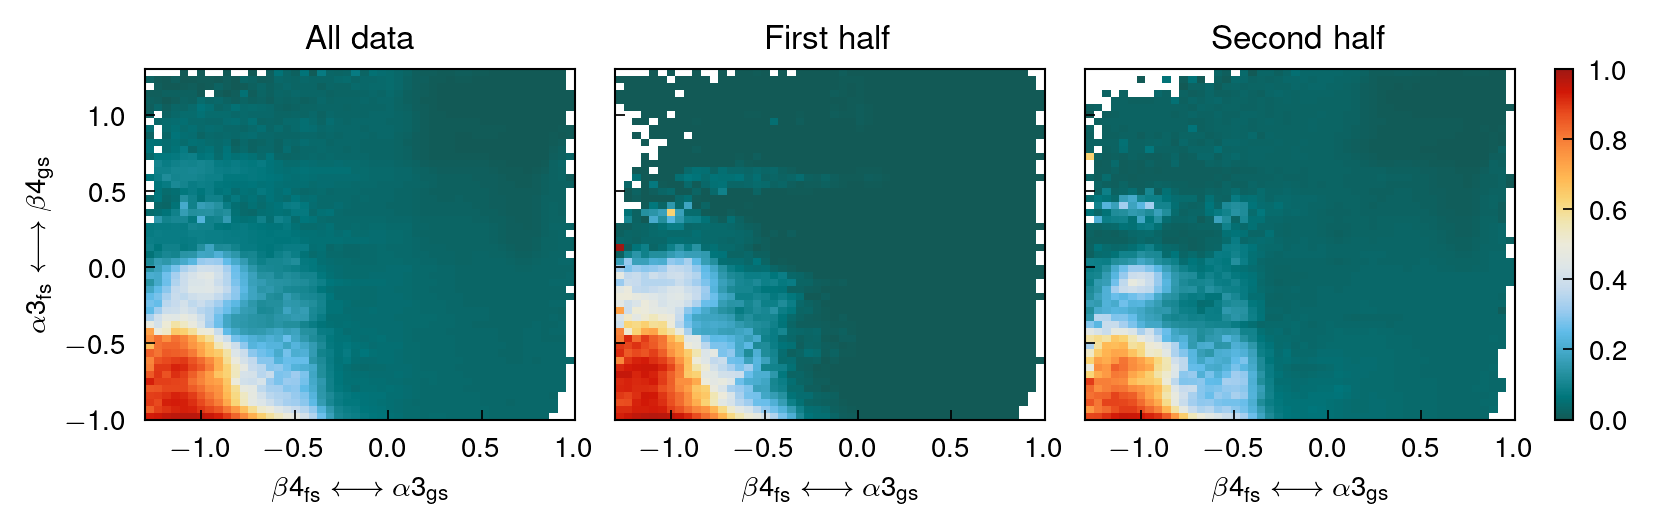

In [19]:
lag = 1000
cv1, cv2 = "green", "blue"
f, axes = plot_q_proj(
    qp_gs2fs[lag],
    qp_gs2fs[(1, lag)],
    qp_gs2fs[(2, lag)],
    cvs[cv1],
    cvs[cv2],
    weights[0],
    weights_block1[0],
    weights_block2[0],
    lims[cv1],
    lims[cv2],
    labels[cv1],
    labels[cv2],
)

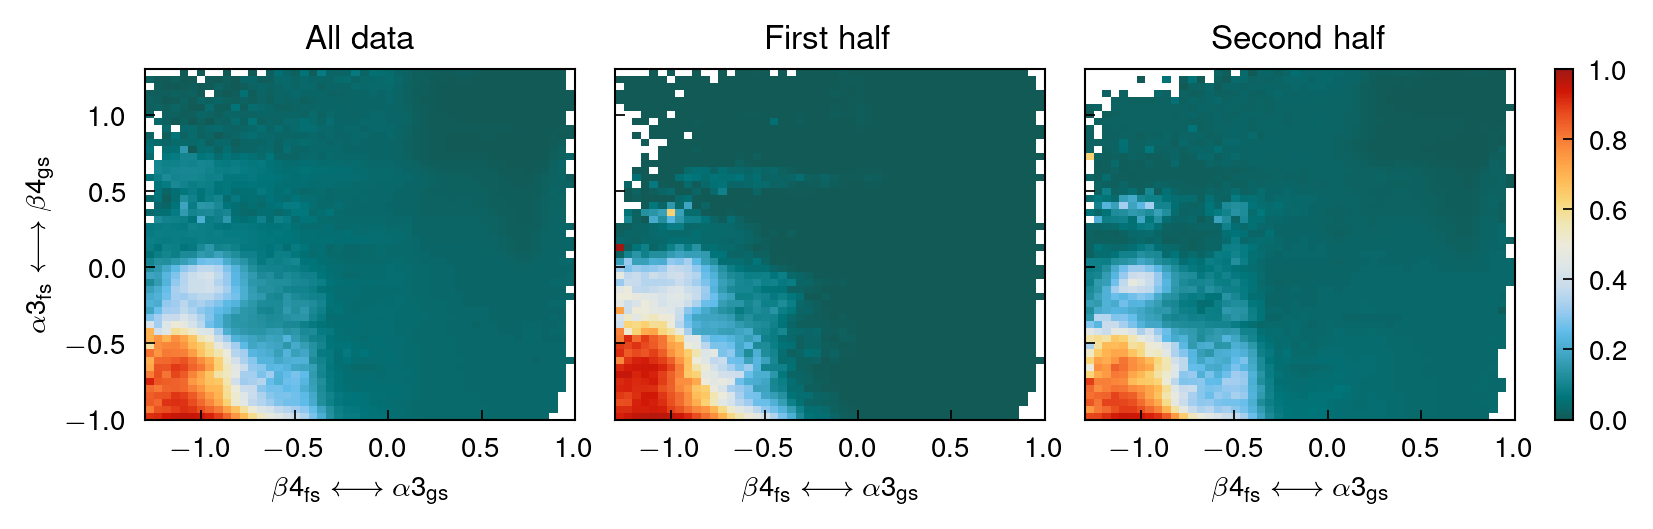

In [20]:
lag = 1000
cv1, cv2 = "green", "blue"
f, axes = plot_q_proj(
    qp_gs2fs[lag],
    qp_gs2fs[(1, lag)],
    qp_gs2fs[(2, lag)],
    cvs[cv1],
    cvs[cv2],
    weights[1],
    weights_block1[0],
    weights_block2[0],
    lims[cv1],
    lims[cv2],
    labels[cv1],
    labels[cv2],
)

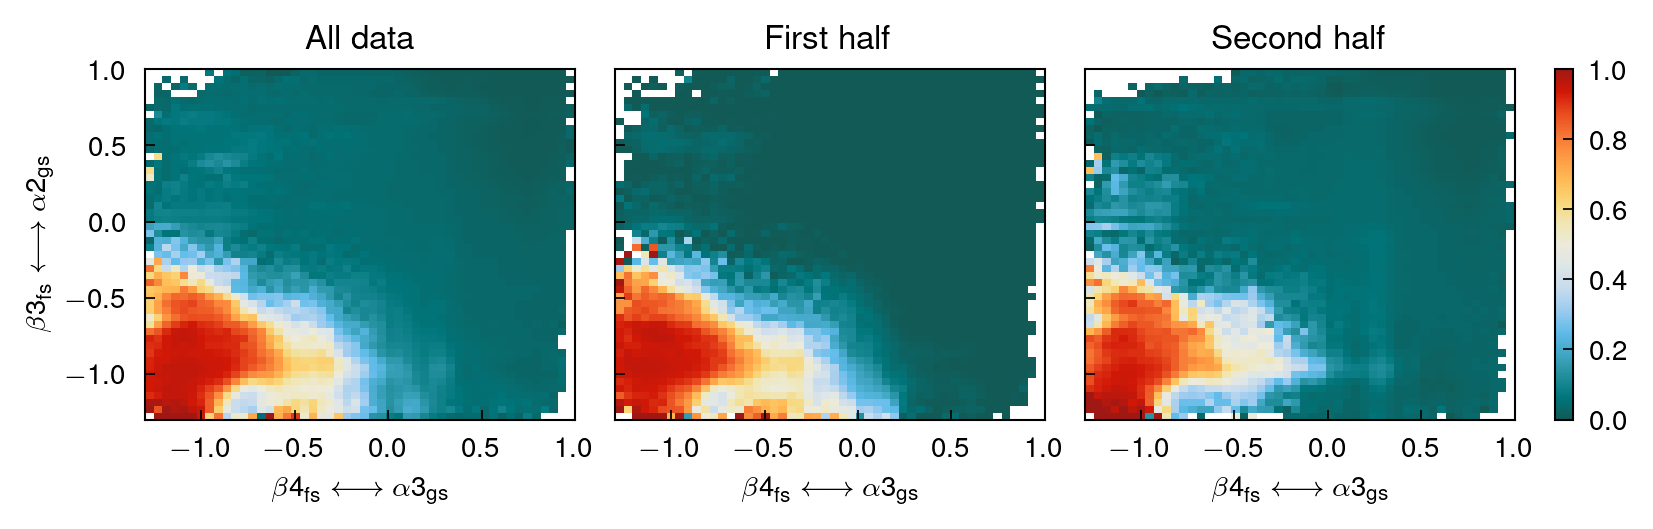

In [21]:
lag = 1000
cv1, cv2 = "green", "orange"
f, axes = plot_q_proj(
    qp_gs2fs[lag],
    qp_gs2fs[(1, lag)],
    qp_gs2fs[(2, lag)],
    cvs[cv1],
    cvs[cv2],
    weights[0],
    weights_block1[0],
    weights_block2[0],
    lims[cv1],
    lims[cv2],
    labels[cv1],
    labels[cv2],
)

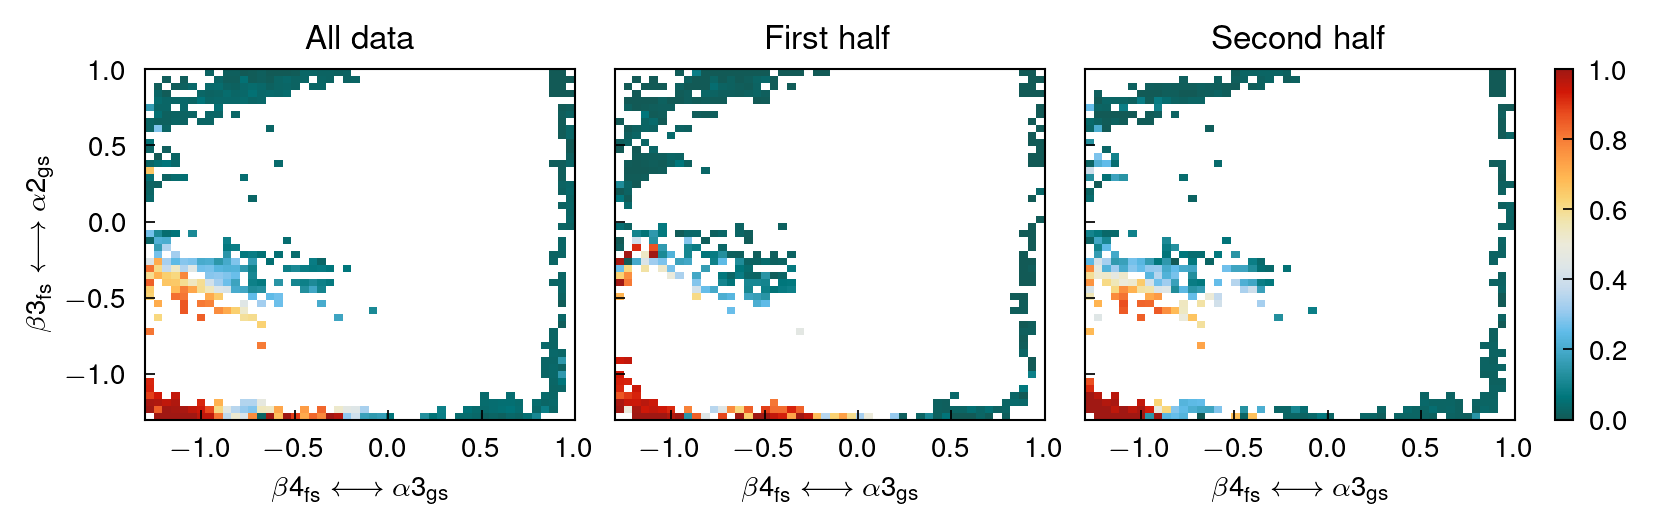

In [25]:
lag = 2000
cv1, cv2 = "green", "orange"
f, axes = plot_q_proj(
    qp_gs2fs[lag],
    qp_gs2fs[(1, lag)],
    qp_gs2fs[(2, lag)],
    cvs[cv1],
    cvs[cv2],
    weights[0],
    weights_block1[0],
    weights_block2[0],
    lims[cv1],
    lims[cv2],
    labels[cv1],
    labels[cv2],
)

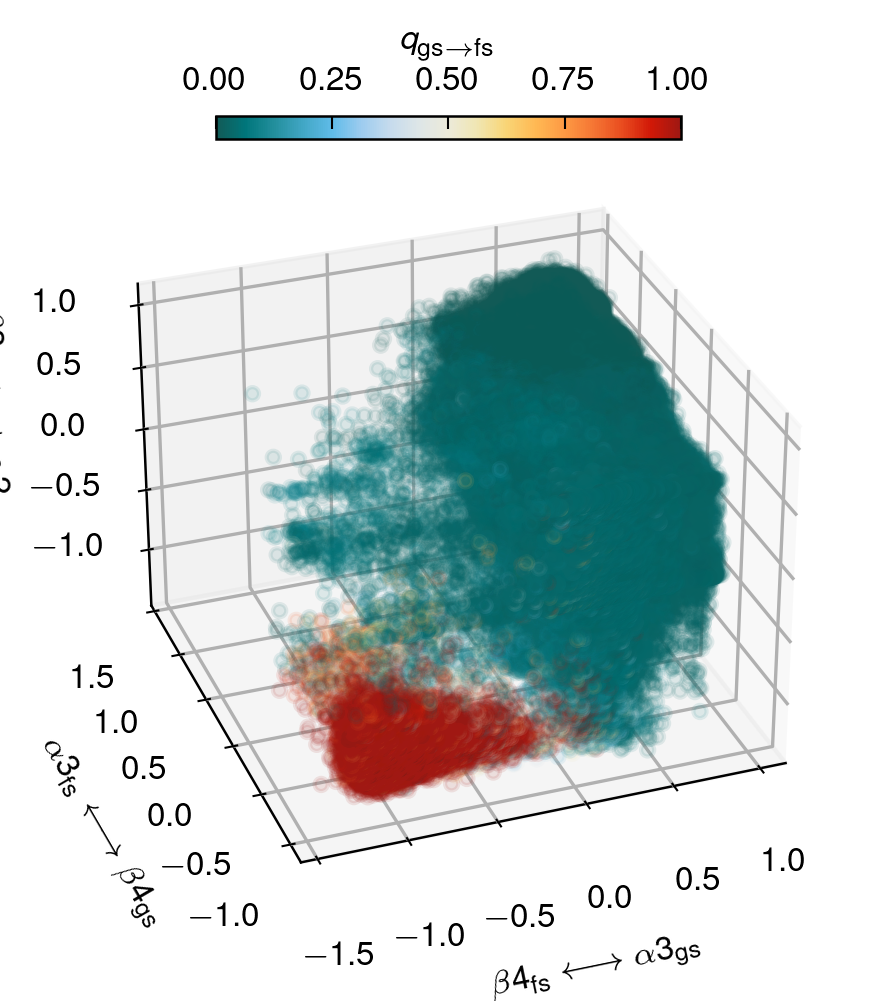

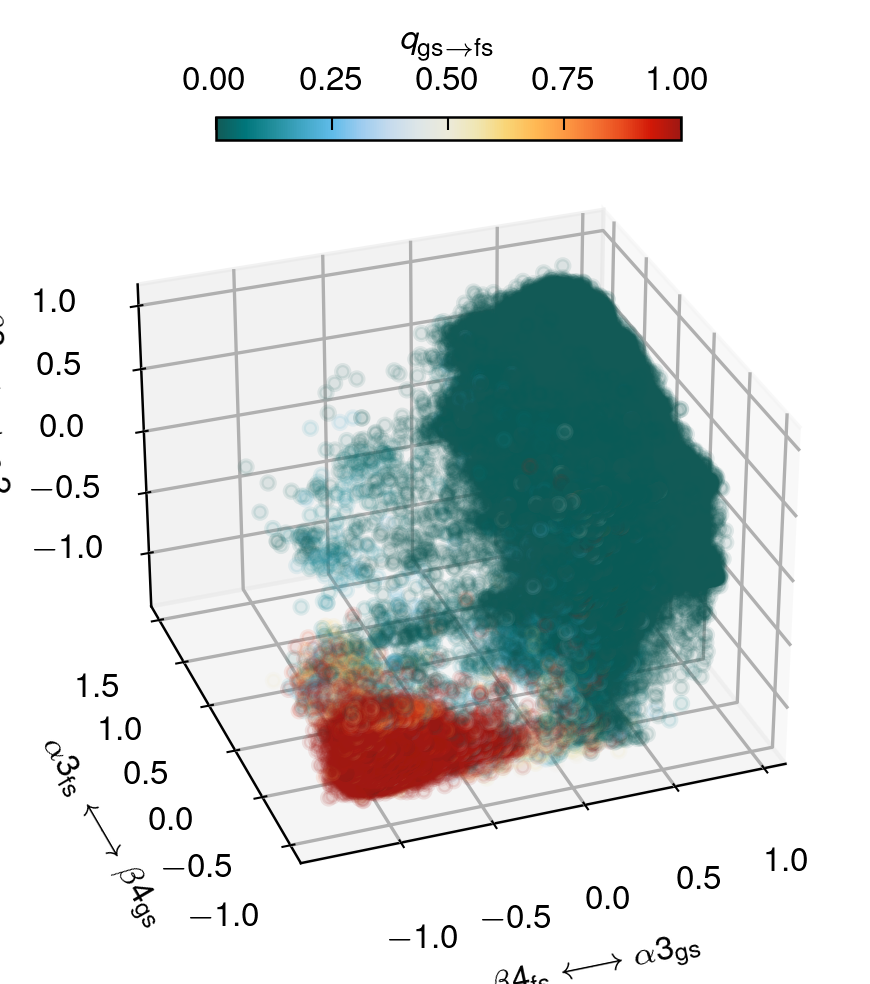

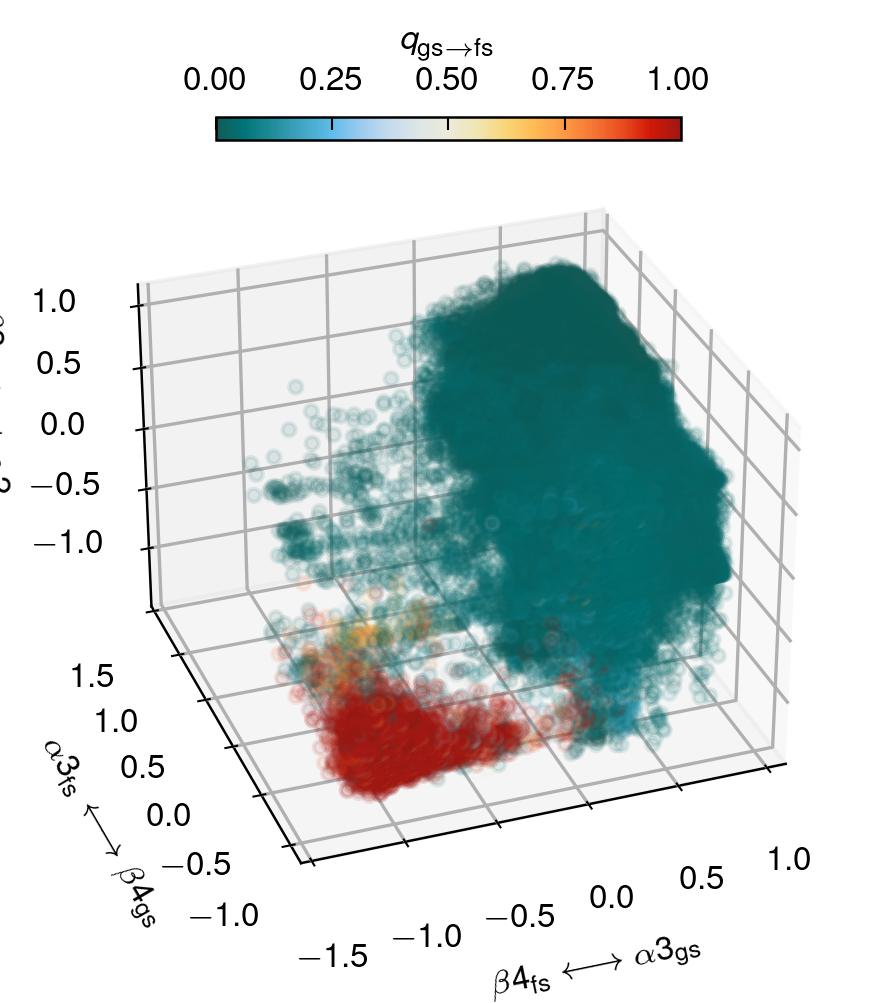

In [22]:
lag = 1000
cv1, cv2, cv3 = "green", "blue", "orange"
plot_q_3d(
    qp_gs2fs[lag],
    qp_gs2fs[(1, lag)],
    qp_gs2fs[(2, lag)],
    cvs[cv1],
    cvs[cv2],
    cvs[cv3],
    labels[cv1],
    labels[cv2],
    labels[cv3],
)

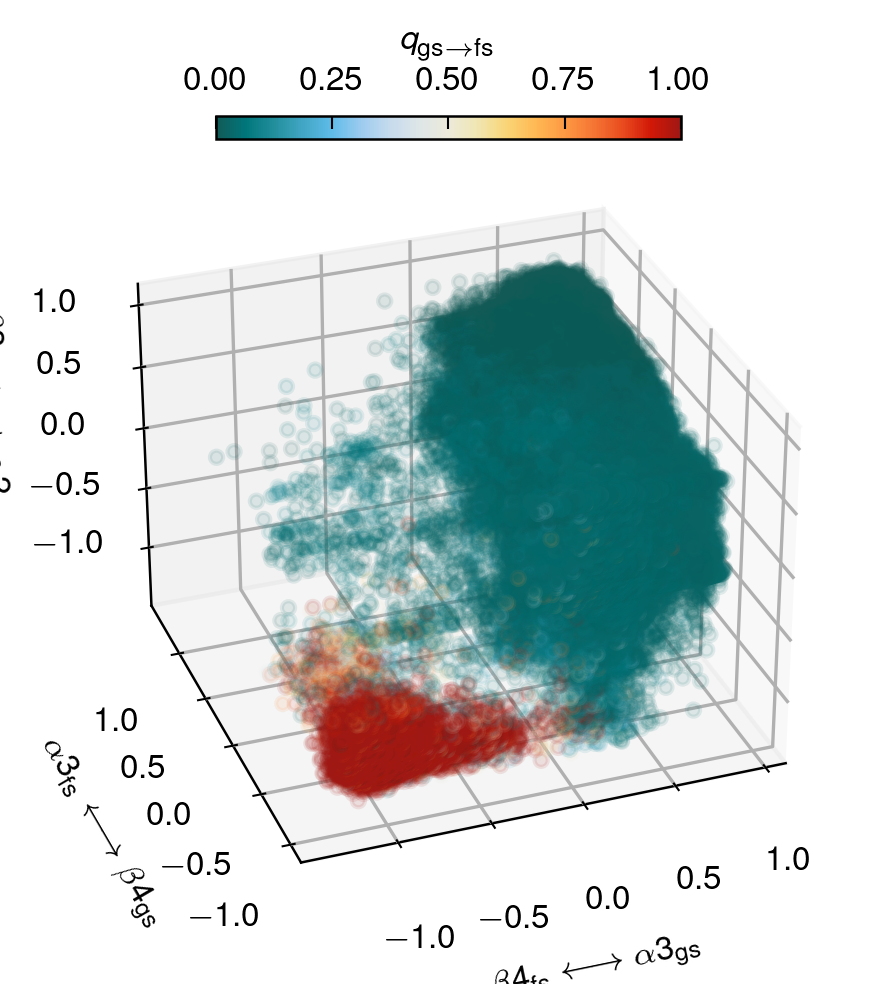

In [23]:
fig = plt.figure(figsize=(4, 4), dpi=300)
q_arr = np.ravel(qp_gs2fs[1000])
N = len(q_arr)
skip = 200
sc_ind = np.random.choice(N, N // skip)

ax = fig.add_subplot(projection="3d")
sc = ax.scatter(
    c_green_arr[sc_ind],
    c_blue_arr[sc_ind],
    c_orange_arr[sc_ind],
    "o",
    c=q_arr[sc_ind],
    cmap="nightfall",
    alpha=0.1,
    s=10,
    rasterized=True,
    vmin=0,
    vmax=1,
)
ax.set_xlabel(labels["green"])
ax.set_ylabel(labels["blue"])
ax.set_zlabel(labels["orange"])
ax.grid(True)
cb = plt.colorbar(sc, ax=ax, shrink=0.5, location="top", pad=0, label=labels["qp"])
cb.solids.set(alpha=1)
ax.view_init(elev=30, azim=-110)

# T = 0.87

In [30]:
home_dir = "/project/dinner/scguo/kaiB"
temp = 87
base_dir = f"/project/dinner/scguo/kaiB/dga/{temp}"

In [31]:
_, fs_qtots, f_rmsds, p_rmsds, r_rmsds, omegas, dssps = load_cvs(base_dir, 7, 32)

In [32]:
# Adam's CVs
c_gsa1 = np.concatenate([traj[1, :] for traj in fs_qtots])
c_gsa2 = np.concatenate([traj[3, :] for traj in fs_qtots])
c_gsb2 = np.concatenate([traj[5, :] for traj in fs_qtots])

c_fsb1 = np.concatenate([traj[0, :] for traj in fs_qtots])
c_fsb2 = np.concatenate([traj[2, :] for traj in fs_qtots])
c_fsa2 = np.concatenate([traj[4, :] for traj in fs_qtots])

c_green_arr = c_gsa2 - c_fsb2
c_blue_arr = c_gsb2 - c_fsa2
c_orange_arr = c_gsa1 - c_fsb1

c_green = [traj[3, :] - traj[2, :] for traj in fs_qtots]
c_blue = [traj[5, :] - traj[4, :] for traj in fs_qtots]
c_orange = [traj[1, :] - traj[0, :] for traj in fs_qtots]

In [33]:
qp_gs2fs = {}
qp_fs2gs = {}
lags = [1000, 2000]
for lag in lags:
    for block in range(1, 3):
        qp_gs2fs[(block, lag)] = np.load(f"{base_dir}/dga_data/qp_gs2fs_lag{lag}_mem4_block{block}.npy")
        qp_gs2fs[lag] = np.load(f"{base_dir}/dga_data/qp_gs2fs_lag{lag}_mem4.npy")
        qp_fs2gs[(block, lag)] = np.load(f"{base_dir}/dga_data/qp_fs2gs_lag{lag}_mem4_block{block}.npy")
        qp_fs2gs[lag] = np.load(f"{base_dir}/dga_data/qp_fs2gs_lag{lag}_mem4.npy")

In [34]:
weights = np.load(f"{base_dir}/dga_data/weights.npy")[3:5]
weights_block1 = np.load(f"{base_dir}/dga_data/weights_block1.npy")[3:5]
weights_block2 = np.load(f"{base_dir}/dga_data/weights_block2.npy")[3:5]

In [37]:
names = ["blue", "green", "orange", "r_rmsd", "qp"]
labels = dict(
    blue=r"$\alpha3_{\mathrm{fs}}\longleftrightarrow \beta4_{\mathrm{gs}}$",
    green=r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$",
    orange=r"$\beta3_{\mathrm{fs}}\longleftrightarrow\alpha2_{\mathrm{gs}}$",
    r_rmsd=r"core RMSD (nm)",
    qp=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$",
)
cvs = dict(blue=c_blue, green=c_green, orange=c_orange, r_rmsd=r_rmsds)
lims = dict(blue=(-1, 1.3), green=(-1.3, 1), orange=(-1.3, 1), r_rmsd=(0, 1.2), qp=(0, 1))

/scratch/local/jobs/11297029/ipykernel_1754184/1631952783.py:13: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(dens)


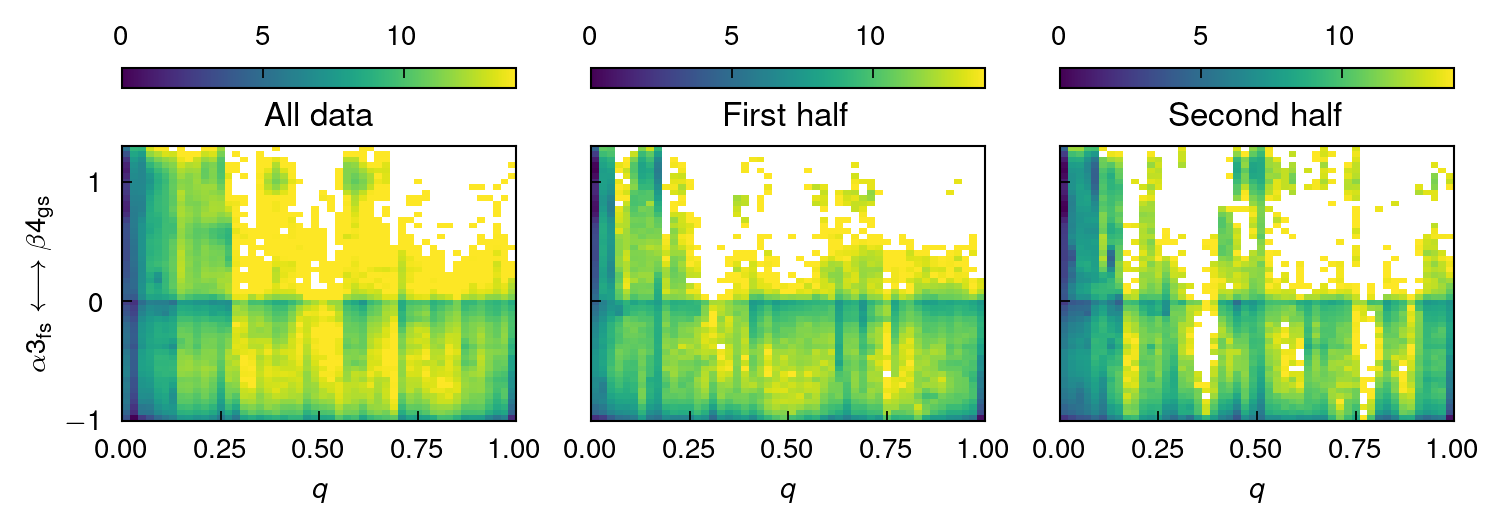

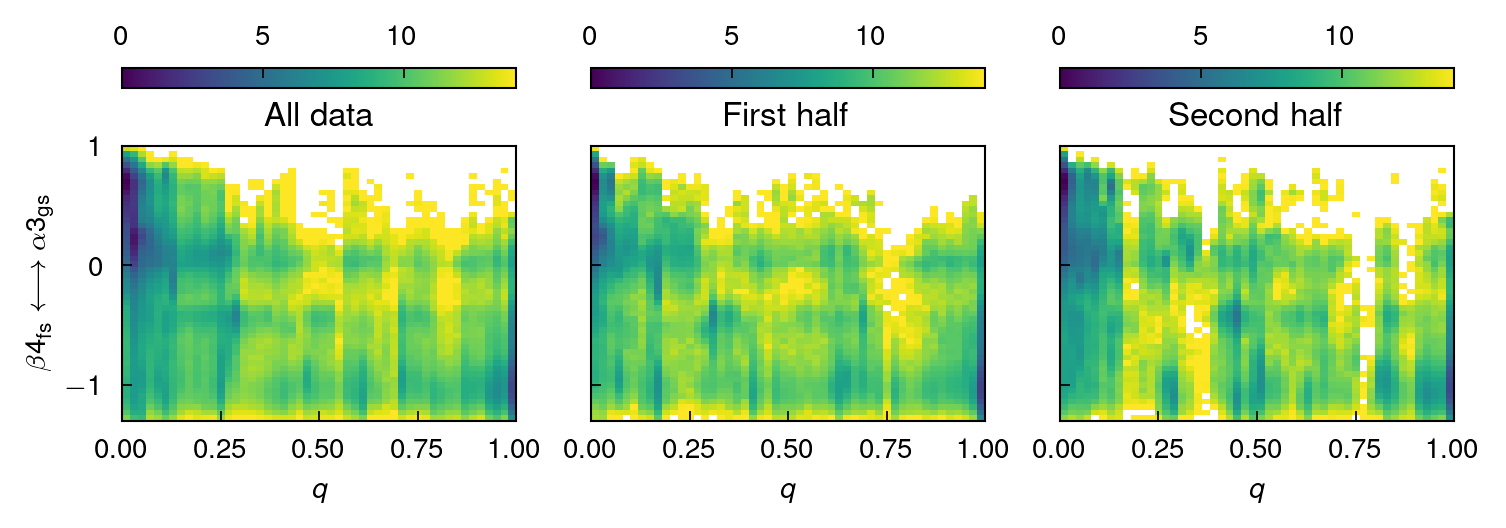

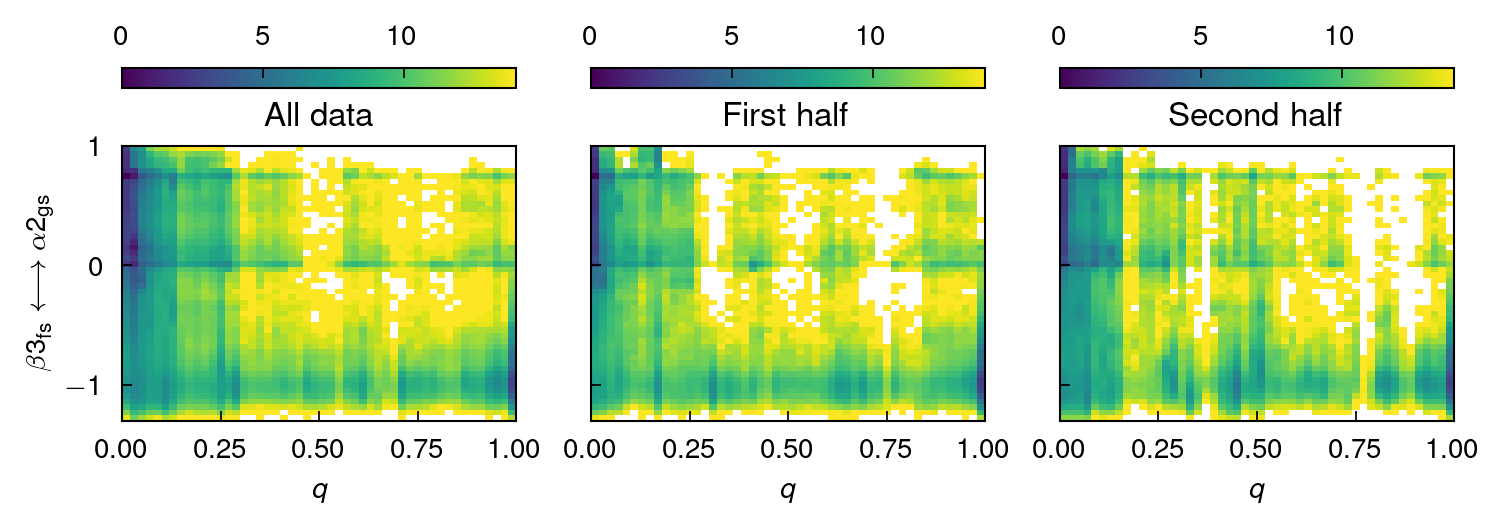

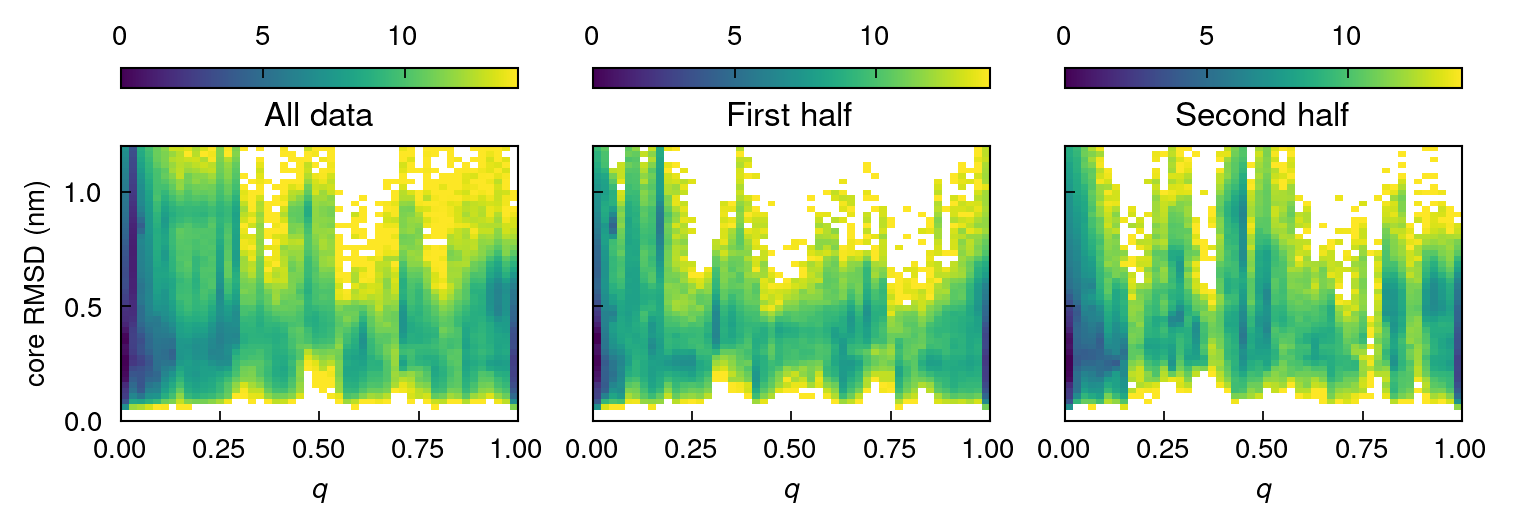

In [38]:
lag = 1000
for name in names[:4]:
    f, axes = plot_q_avg(
        qp_gs2fs[lag],
        qp_gs2fs[(1, lag)],
        qp_gs2fs[(2, lag)],
        cvs[name],
        weights[0],
        weights_block1[0],
        weights_block2[0],
        lims[name],
        labels[name],
    )

/project/dinner/scguo/extq/src/extq/projection.py:145: RuntimeWarning: invalid value encountered in divide
  return numer / denom


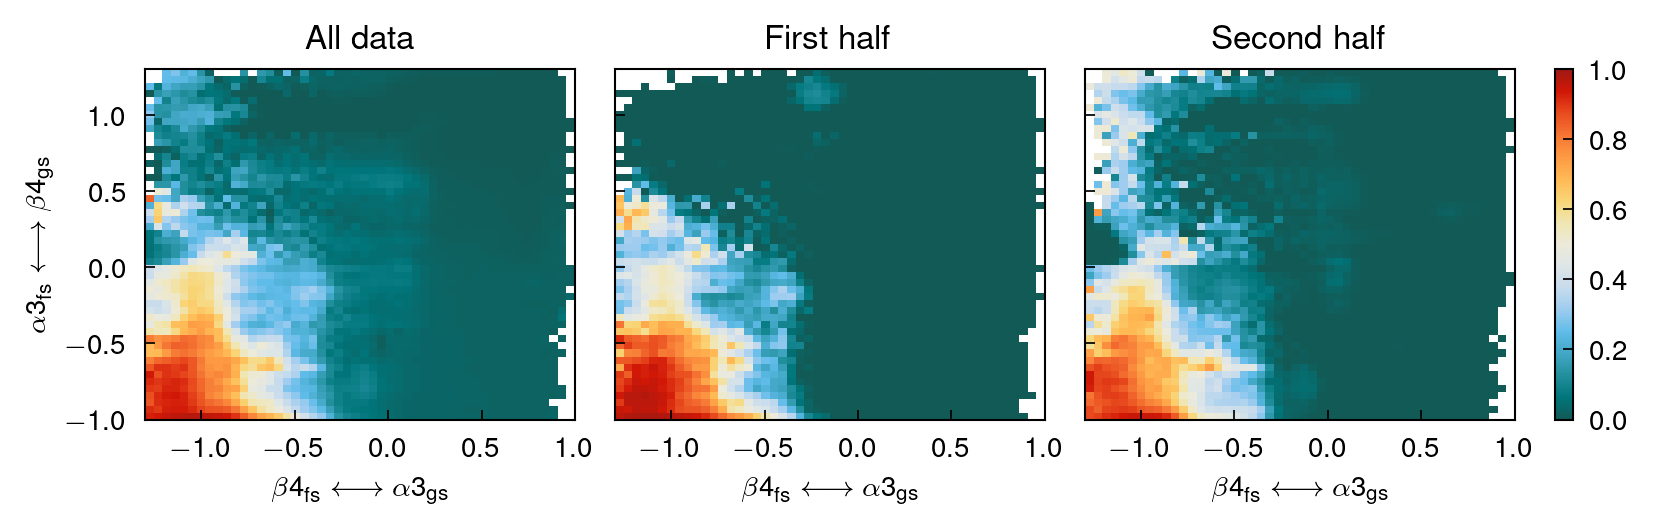

In [39]:
lag = 1000
cv1, cv2 = "green", "blue"
f, axes = plot_q_proj(
    qp_gs2fs[lag],
    qp_gs2fs[(1, lag)],
    qp_gs2fs[(2, lag)],
    cvs[cv1],
    cvs[cv2],
    weights[0],
    weights_block1[0],
    weights_block2[0],
    lims[cv1],
    lims[cv2],
    labels[cv1],
    labels[cv2],
)

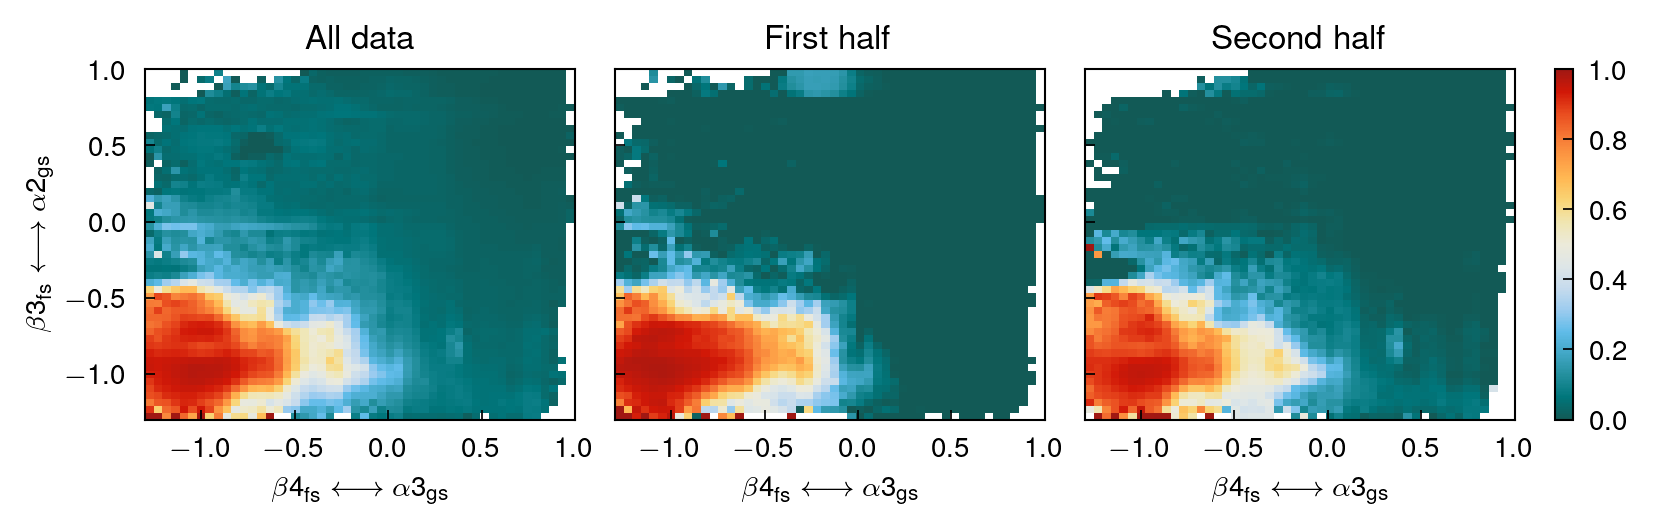

In [42]:
lag = 1000
cv1, cv2 = "green", "orange"
f, axes = plot_q_proj(
    qp_gs2fs[lag],
    qp_gs2fs[(1, lag)],
    qp_gs2fs[(2, lag)],
    cvs[cv1],
    cvs[cv2],
    weights[0],
    weights_block1[0],
    weights_block2[0],
    lims[cv1],
    lims[cv2],
    labels[cv1],
    labels[cv2],
)

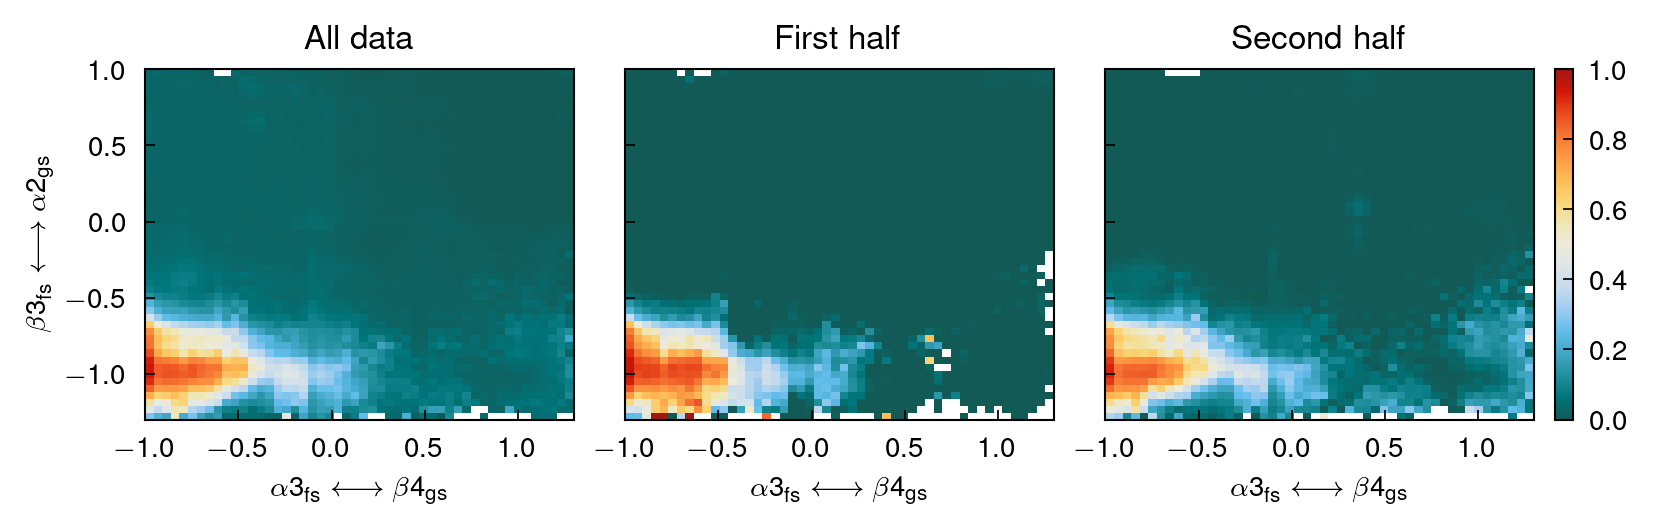

In [47]:
lag = 1000
cv1, cv2 = "blue", "orange"
f, axes = plot_q_proj(
    qp_gs2fs[lag],
    qp_gs2fs[(1, lag)],
    qp_gs2fs[(2, lag)],
    cvs[cv1],
    cvs[cv2],
    weights[0],
    weights_block1[0],
    weights_block2[0],
    lims[cv1],
    lims[cv2],
    labels[cv1],
    labels[cv2],
)

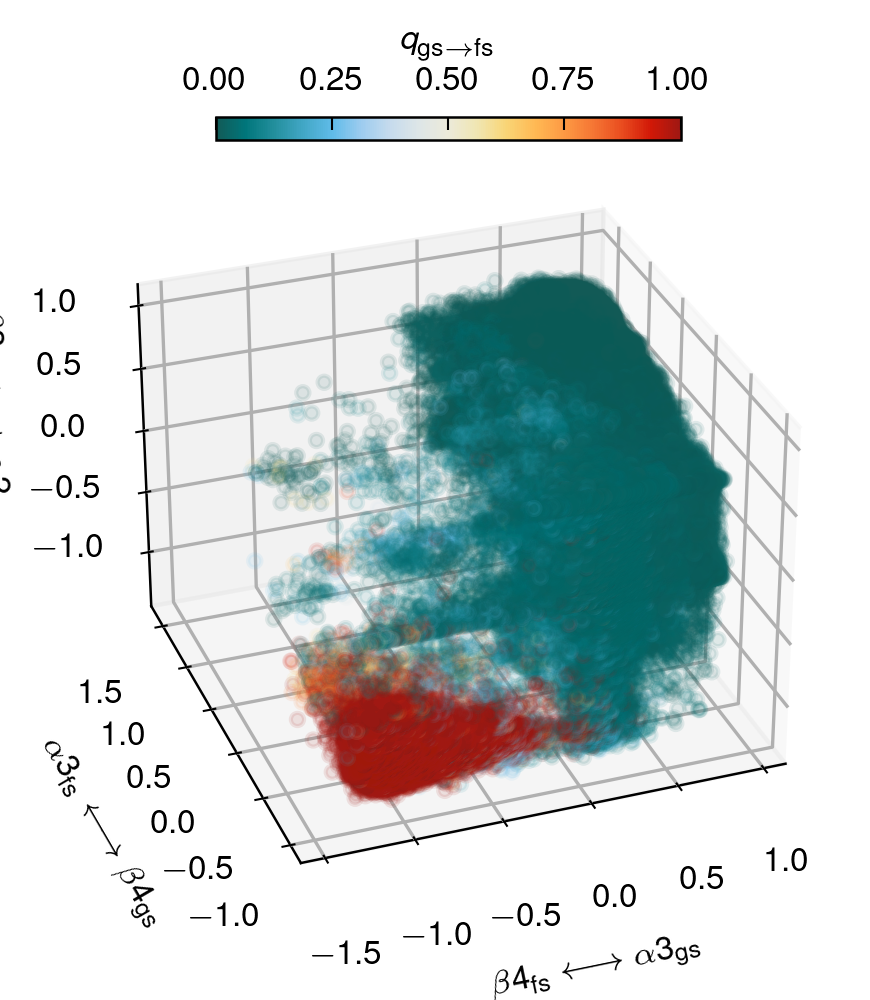

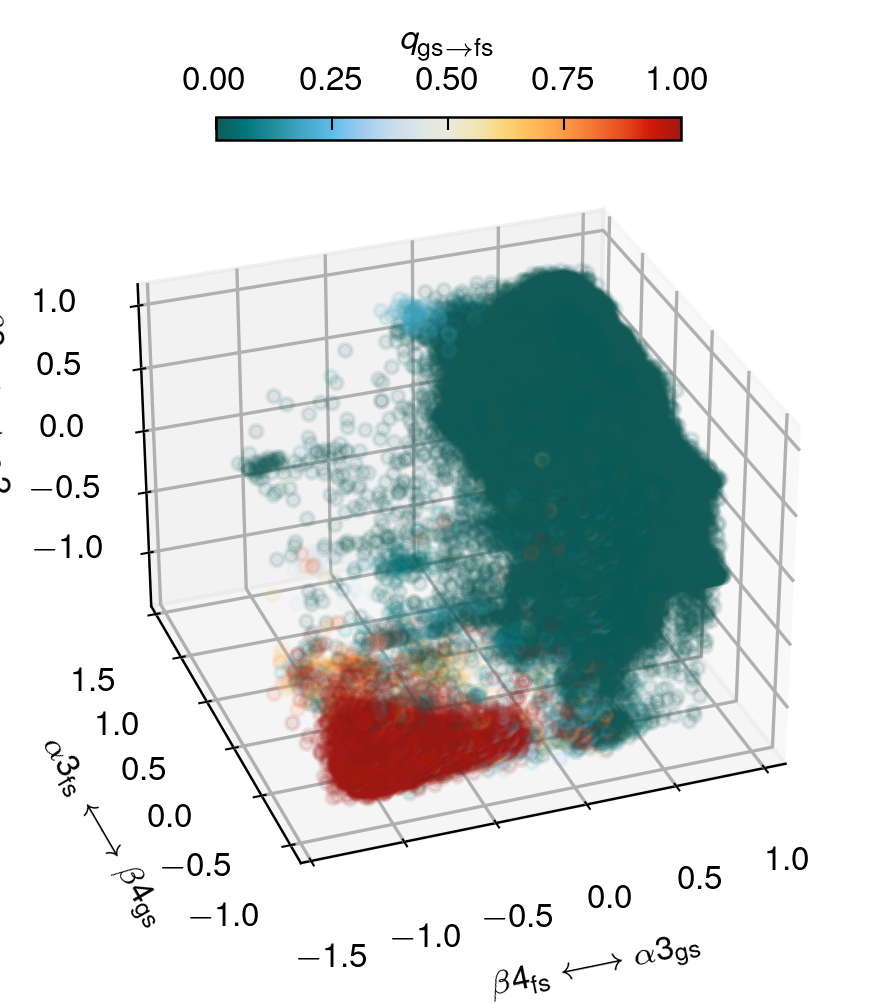

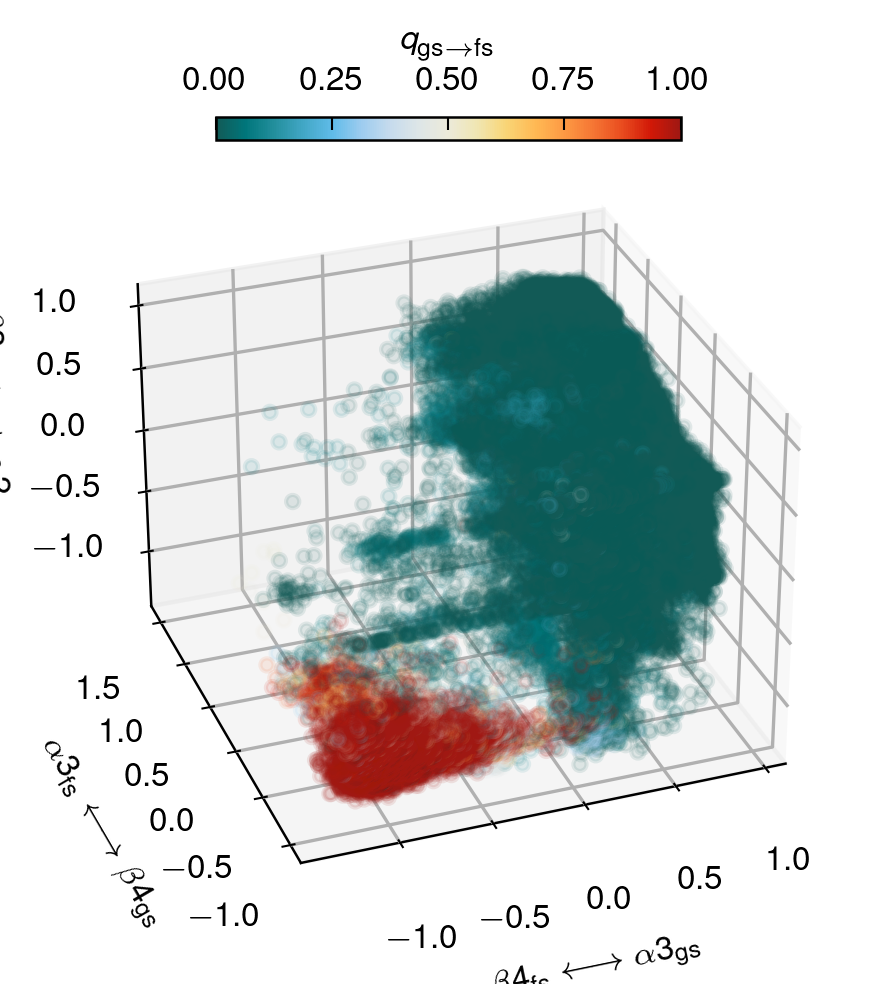

In [44]:
lag = 1000
cv1, cv2, cv3 = "green", "blue", "orange"
plot_q_3d(
    qp_gs2fs[lag],
    qp_gs2fs[(1, lag)],
    qp_gs2fs[(2, lag)],
    cvs[cv1],
    cvs[cv2],
    cvs[cv3],
    labels[cv1],
    labels[cv2],
    labels[cv3],
)

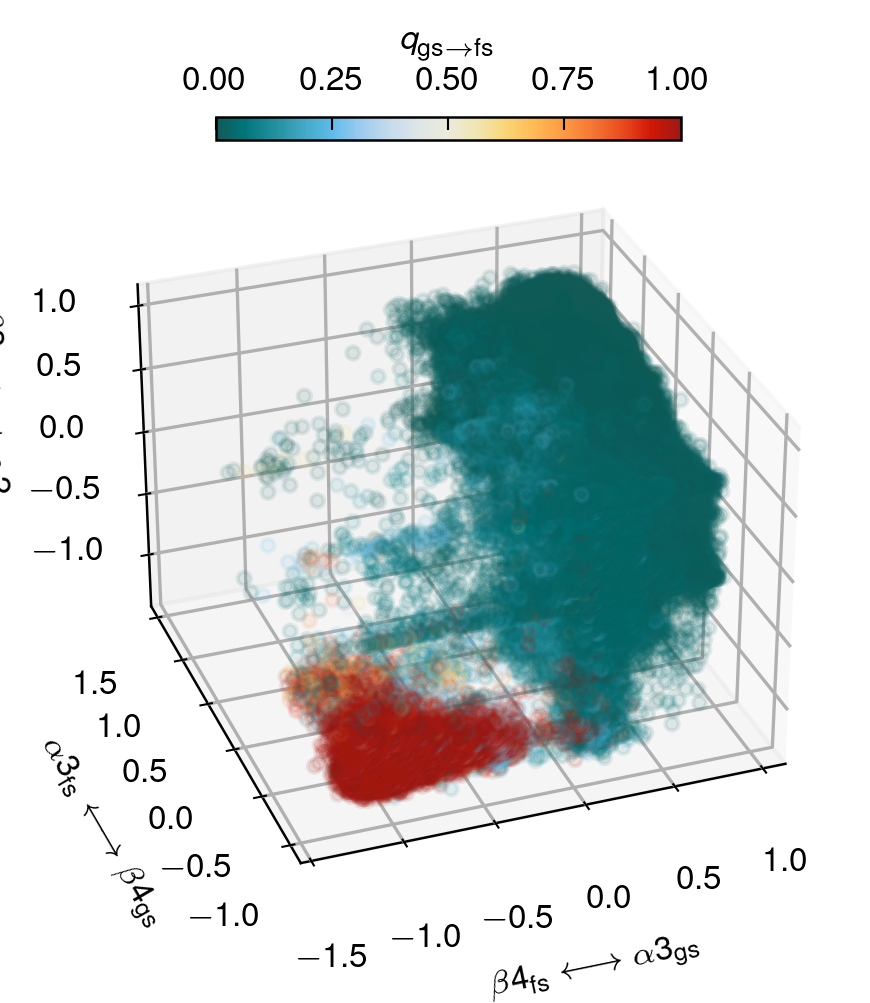

In [45]:
fig = plt.figure(figsize=(4, 4), dpi=300)
q_arr = np.ravel(qp_gs2fs[1000])
N = len(q_arr)
skip = 200
sc_ind = np.random.choice(N, N // skip)

ax = fig.add_subplot(projection="3d")
sc = ax.scatter(
    c_green_arr[sc_ind],
    c_blue_arr[sc_ind],
    c_orange_arr[sc_ind],
    "o",
    c=q_arr[sc_ind],
    cmap="nightfall",
    alpha=0.1,
    s=10,
    rasterized=True,
    vmin=0,
    vmax=1,
)
ax.set_xlabel(labels["green"])
ax.set_ylabel(labels["blue"])
ax.set_zlabel(labels["orange"])
ax.grid(True)
cb = plt.colorbar(sc, ax=ax, shrink=0.5, location="top", pad=0, label=labels["qp"])
cb.solids.set(alpha=1)
ax.view_init(elev=30, azim=-110)

In [ ]:
lag = 1000
traj_len = len(omegas[0])
state_dict, dtrajall = assign_proline_states(omegas)
_, dtraj1 = assign_proline_states(np.array(omegas)[:, : traj_len // 2])
_, dtraj2 = assign_proline_states(np.array(omegas)[:, traj_len // 2 :])

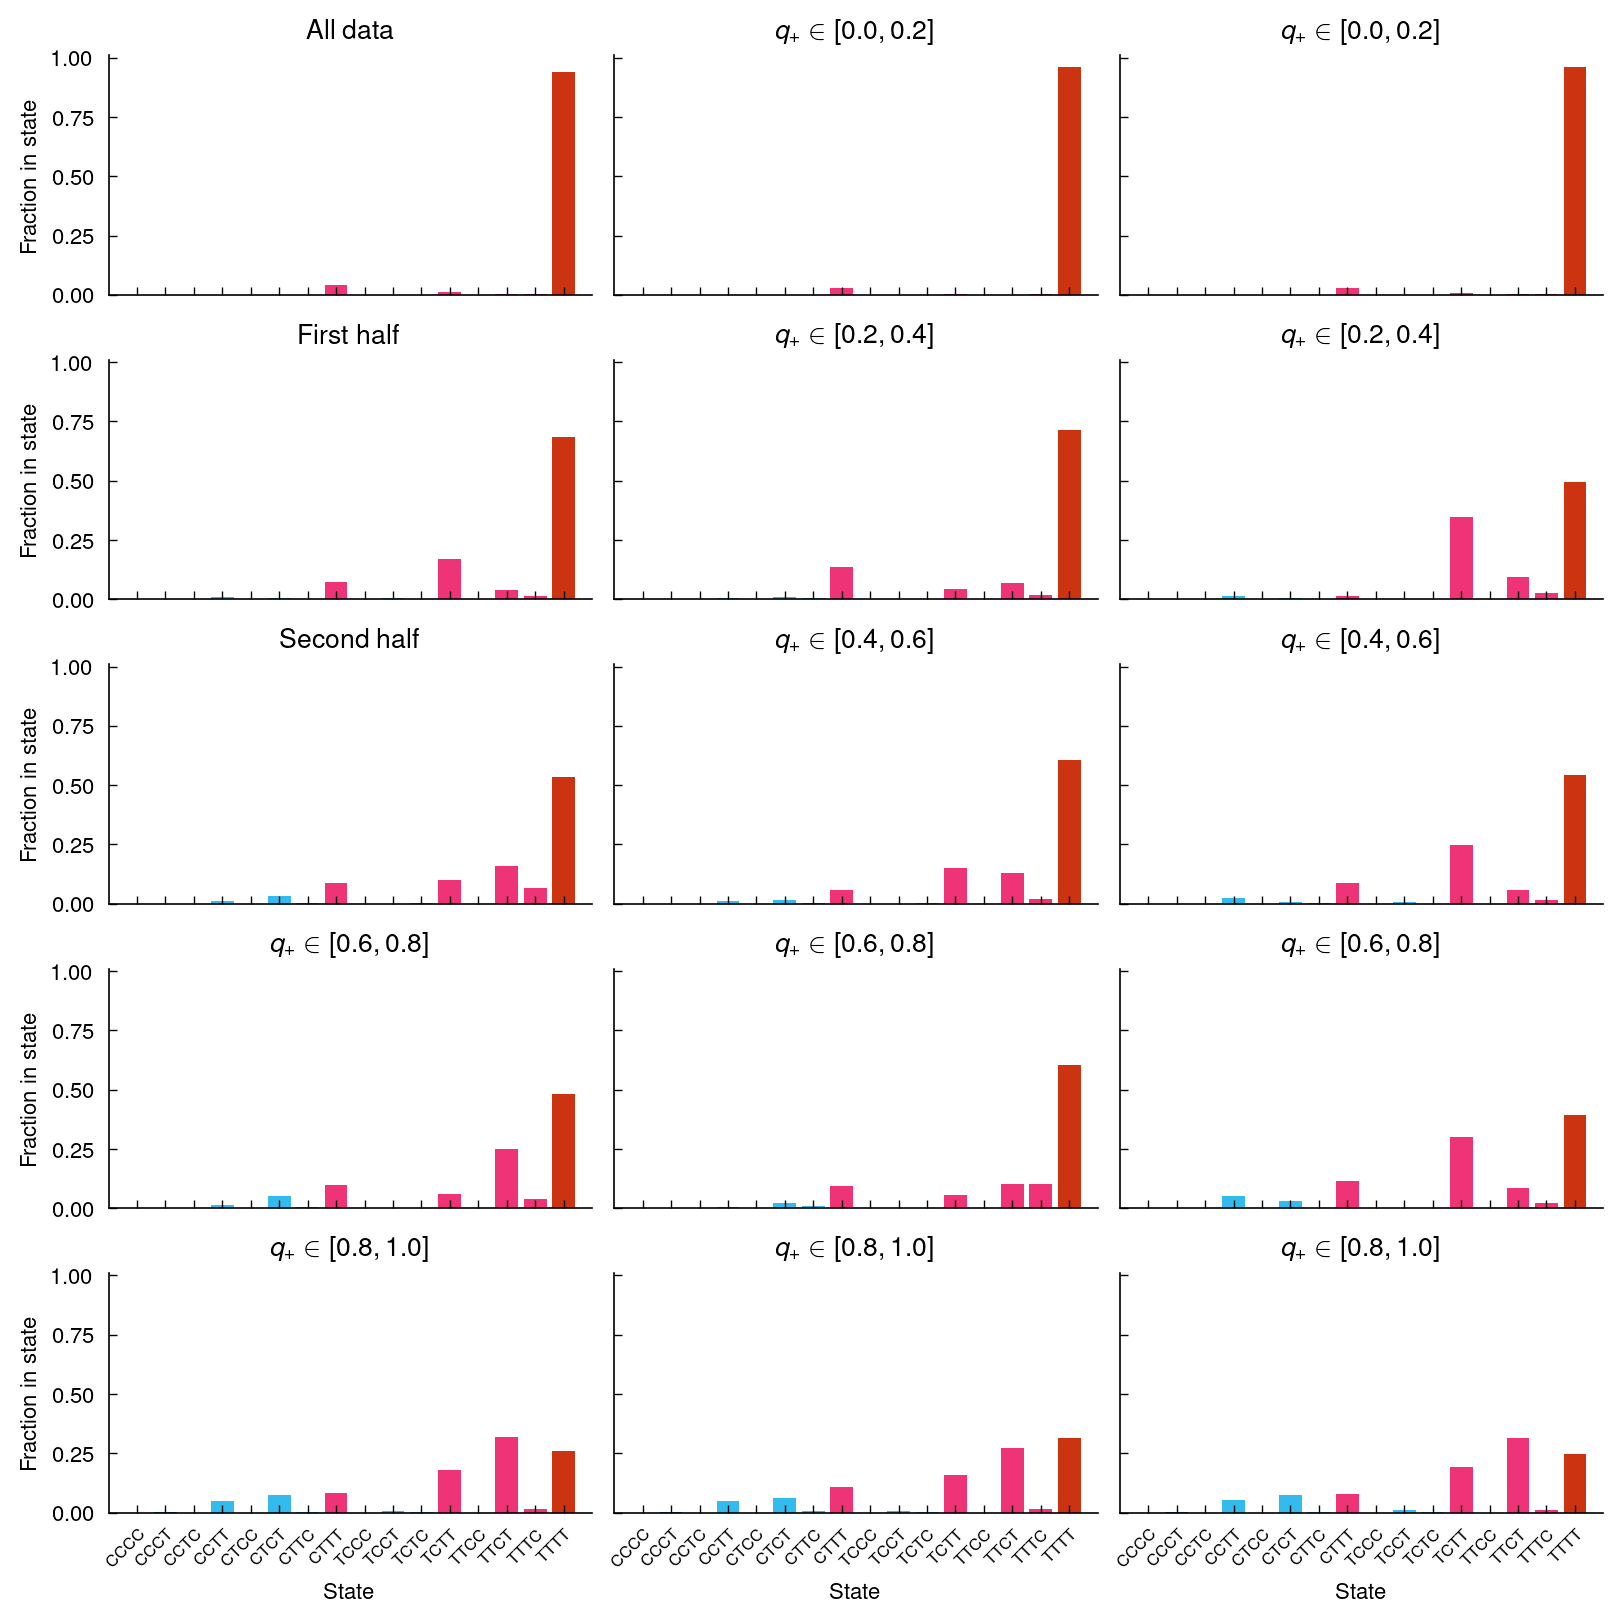

In [63]:
plot_proline_states(
    qp_gs2fs[lag], qp_gs2fs[(1, lag)], qp_gs2fs[(2, lag)], dtrajall, dtraj1, dtraj2, state_dict
)